# Marcov Decision Process

### Introduction

##### Шашки

В качестве примера марковского процесса принятия решений можно привести множество настольных игр, например, шашки. Действительно, для того, кто играет за белых, процесс описывается следующим образом:
1.  Агент - сам игрок.
2.  Среда - соперник, играющий за черных.
3.  Состояния - позиции на доске, которые могли получиться за четное число полуходов (т.е. позиции перед ходом белых). Т.к. всех возможных расстановок шашек на доске конечно, то и множество состояний конечно.
4.  Множество действий в каждом состоянии - возможные ходы в текущей позиции. Их объединение по всем состояниям даст множество всех действий.
5.  Награда за промежуточный ход - 0, за победу - 1, за поражение - (-1).

Ясно, что в такой естественной модели решение не зависит от предыдущих состояний и выбранных действий. Поэтому мы получаем марковский процесс. Заметим, что агенту неизвестно распределение вероятностей, т.е. ходов соперника.

##### Шахматы

Примером настольной игры, где естественная модель не будет являться марковским процессом, являются шахматы. Допустим, мы хотим модель, аналогичную описанной для шашек, где в качестве состояний используются позиции на доске. Однако здесь возникнут проблемы, связанные со спецификой правил:
1.  Если король или ладья совершали ход в течении партии, а после вернулись на исходные клетки, рокировку в соответствующую сторону делать нельзя. Но, лишь глядя на позицию, этого определить не получится.
2.  Если пешка сходила с исходной клетки на две клетку вперед и оказалась на одной горизонтали и на соседней вертикали с пешкой оппонента, последний имеет право на взятие на проходе. Если же пешка попала в аналогичную позицию за два хода, взятие на проходе не допускается. Отметим, что и эту ситуацию невозможно определить, имея информацию лишь о текущем расположении фигур.
3.  Игрок имеет право потребовать ничью (т.е. прийти в терминальное состояние в рамках модели), если за последние 50 ходов ни одна пешка не делала ход и ни одна фигура не была срублена. Это также невозможно определить по позиции.

Таким образом, в рамках естественной модели для шахмат не получится даже определить возможные действия из некоторых состояний. Значит, такая модель не будет представлять из себя марковский процесс принятия решений, т.к. последующие действия зависят от предыдущих действий и состояний.

##### Связь значений

Рассмотрим, как связаны некоторые значения в рамках рассматриваемой модели:

1.  $r(s, a) = \sum_{s', r}rp(s', r'|s, a)$ - средняя награда из состояния $s$ по действию $a$.
2.  $p(s'|s, a) = \sum_r p(s', r|s, a)$ - вероятность перехода в состояние $s'$ из состояния $s$ по действию $a$.
3.  Средний выигрыш по переходу из $s$ в $s'$ по действию $a$: $$r(s, a, s') = \frac{\sum_rp(s', r|s, a)}{p(s'|s, a)}.$$

Перейдем к реализации. Для удобства будем считать, что нам заранее известны средние значения выигрышей по конкретным переходам.

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(42)

In [185]:
class Environment(object):
    def __init__(self, states, actions):
        self.probabilities = np.zeros((actions, states, states))
        self.rewards = np.zeros((actions, states, states))
        for action in range(actions):
            for state in range(states):
                mask = np.random.random(states)
                p = np.random.random() / 2 + 0.25
                mask[mask >= p] = 1
                mask[mask < p] = 0
                if mask.max() == 0:
                    mask[np.random.randint(0, states)] = 1
                self.probabilities[action, state, :] = np.random.random(states) * mask
                self.probabilities[action, state, :] /= self.probabilities[action, state, :].sum()
                self.rewards[action, state, :] = (np.random.poisson(lam=10, size=states)) * mask
    
    def getTransitions(self):
        return self.probabilities
    
    def getRewards(self):
        return self.rewards

In [258]:
'''Markov Decision Process model
        
S - number of states
A - number of actions

T = array[A x S x S] - matrix of transition probabilities:
    T[a, s1, s2] - probability of state s2, when action a is chosen in state s1
R = array[A x S x S] - matrix of expected rewards:
    R[a, s1, s2] - expected reward for transition from state s1 to state s2 by action a

discount - coefficient of discounting from [0, 1)

V = array[S] - state-value function
Q = array[A x S] - action-value function

policy = array[A x S] - policy: policy[a, s] - probability of choosing action a in state s

'''

class MDP(object):
    def __init__(self, transitions, rewards, discount):        
        self.S = transitions.shape[1]
        self.A = transitions.shape[0]
        self.T = transitions
        self.R = rewards
        self.discount = discount
        self.V = np.random.normal(size=self.S)
        self.Q = np.zeros((self.A, self.S))
        self.__initPolicy__()
    
    def __initPolicy__(self):
        self.policy = np.zeros((self.A, self.S))
        # choosing policy that maximizes immediate reward in every state
        for state in range(self.S):
            actions_exp_rewards = self.__calculateActionRewards__(state, discounting=0)
            best_actions = np.where(actions_exp_rewards == np.max(actions_exp_rewards))[0]
            for action in best_actions:
                self.policy[action, state] = 1 / best_actions.shape[0]
    
    def __iterativePolicyEval__(self, epsilon, max_iter=1000):
        done = 0
        iteration = 0
        while not done:
            iteration += 1
            V_prev = np.copy(self.V)
            for state in range(self.S):
                actions_exp_rewards = self.__calculateActionRewards__(state)
                self.V[state] = np.sum(actions_exp_rewards * self.policy[:, state], axis=0)
                
            variation = np.abs(V_prev - self.V).max()
            if variation < epsilon or iteration > max_iter:
                done = 1
        return iteration, variation
    
    def __policyImprovement__(self):
        for state in range(self.S):
            old_actions = np.copy(self.policy[:, state])
            actions_exp_rewards = self.__calculateActionRewards__(state)
            best_actions = np.where(actions_exp_rewards == np.max(actions_exp_rewards))[0]
            self.policy[:, state] = 0
            for action in best_actions:
                self.policy[action, state] = 1 / best_actions.shape[0]
            if not np.all(self.policy[:, state] == old_actions):
                self.stable_policy = 0
            del old_actions
    
    def policyIteration(self, epsilon=1e-4, verbose=0):
        time0 = time.time()
        self.stable_policy = 0
        inner_iterations = 0
        while not self.stable_policy:
            current_iterations, variation = self.__iterativePolicyEval__(epsilon=epsilon)
            inner_iterations += current_iterations
            self.stable_policy = 1
            self.__policyImprovement__()
            if verbose:
                print('Iterations: ' + str(inner_iterations), end='\t')
                print('\ttime: ' + str(time.time() - time0), end='\t')
                print('\tVariation: ' + str(variation))
            
    def valueIteration(self, epsilon=1e-4, verbose=0):
        delta = epsilon
        time0 = time.time()
        iters = 1
        variation = 0
        while delta >= epsilon:
            delta = 0
            for state in range(self.S):
                v_prev = self.V[state]
                actions_exp_rewards = self.__calculateActionRewards__(state)
                self.V[state] = np.max(actions_exp_rewards)
                variation = np.abs(v_prev - self.V[state])
                delta = max(variation, delta)
            if verbose:
                print('Iteration: ' + str(iters), end='\t')
                print('\ttime: ' + str(time.time() - time0), end='\t')
                print('\tVariation: ' + str(variation))
            iters += 1
        self.__policyImprovement__()        
    
    def  __calculateActionRewards__(self, state, discounting=1):
        return np.sum(self.T[:, state, :] * (self.R[:, state, :] + \
                                             discounting * self.discount * self.V), axis=1)
    
    def getPolicy(self):
        return self.policy
    
    def getStateEval(self):
        return self.V

In [259]:
S = 100
A = 50

env = Environment(S, A)
P = env.getTransitions()
R = env.getRewards()

In [261]:
mdpVI = MDP(P, R, 0.8)
mdpVI.valueIteration(1e-4, verbose=1)

Iteration: 1		time: 0.002408742904663086		Variation: 26.7953958451
Iteration: 2		time: 0.0050508975982666016		Variation: 10.9765613839
Iteration: 3		time: 0.007617473602294922		Variation: 6.9716507175
Iteration: 4		time: 0.010254144668579102		Variation: 4.40724357438
Iteration: 5		time: 0.012814521789550781		Variation: 2.79946207986
Iteration: 6		time: 0.0154266357421875		Variation: 1.79200882536
Iteration: 7		time: 0.01811361312866211		Variation: 1.15996750713
Iteration: 8		time: 0.020897388458251953		Variation: 0.755922801058
Iteration: 9		time: 0.02356553077697754		Variation: 0.492559961996
Iteration: 10		time: 0.02637958526611328		Variation: 0.321285596731
Iteration: 11		time: 0.028989791870117188		Variation: 0.209807699597
Iteration: 12		time: 0.031696319580078125		Variation: 0.137208060485
Iteration: 13		time: 0.0344693660736084		Variation: 0.0897492666366
Iteration: 14		time: 0.03711748123168945		Variation: 0.058718488789
Iteration: 15		time: 0.039899349212646484		Variation: 0.0

In [262]:
mdpPI = MDP(P, R, 0.8)
mdpPI.policyIteration(1e-4, verbose=1)

Iterations: 31		time: 0.07897281646728516		Variation: 7.27573425294e-05
Iterations: 42		time: 0.10623669624328613		Variation: 9.32815189927e-05


In [263]:
(mdpPI.getPolicy() == mdpVI.getPolicy()).sum()

5000

In [266]:
discounters = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
values = np.zeros((len(discounters), S))
for d in range(len(discounters)):
    mdp = MDP(P, R, discounters[d])
    mdp.policyIteration(1e-6)
    values[d, :] = mdp.getStateEval()

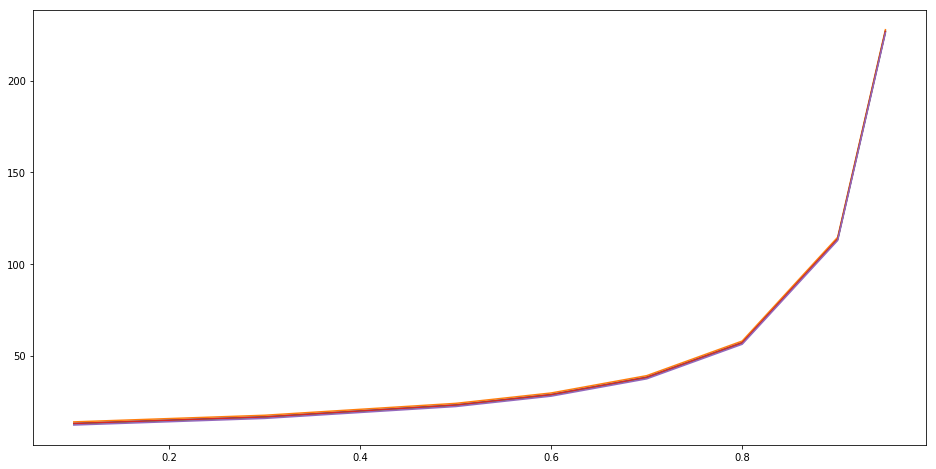

In [267]:
fig = plt.figure(figsize=(16, 8))

states = [0, 1, 2, 3, 4]

for s in range(len(states)):
    plt.plot(discounters, values[:, s])

plt.show()